# Deep Reinforcement Learning with Keras

In this short project we are gonna **train a neural network to play Pong game** using a reinforcement learning algorithm (**Policy Gradients Method - REINFORCE**). 

Considering **limited time** and for **learning purposes** I am **not aiming for a perfect trained agent**, but i hope this project could help people get familiar with basic process of rl algorithms and keras. The following video took 3 days for agent to learn on a slow computer. to obtain production results, a lot of more training and tuning is required which is not our focus. 

prerequisites:
familiarity with neural networks,supervised learning, tensorflow and keras, openai gym

in the learning phase the policy can output the probability of each action and we sample from that probability.
in the playing phase we may opt to pick the most probable action. or just sample like the training phase

# 2. Defining the approach 

In [1]:
import gym # i used 0.10.5
import numpy as np # i used 1.14.3
import datetime
import keras # i used 2.1.16 with tensorflow 1.8.0/

Using TensorFlow backend.


### first lets see the game

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
env = gym.make('Pong-v0')
observation = env.reset()
observation.shape

C:\ProgramData\Miniconda3\lib\site-packages\gym\envs\registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


(210, 160, 3)

the observation is an image of size 210*160 with 3 channels (rgb)

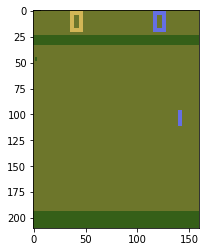

In [4]:
plt.imshow(observation)

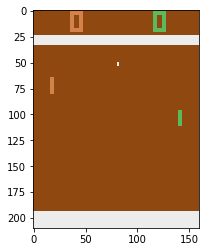

In [6]:
# i take some steps to see middle game scene
# in pong game,
# 0 is numeric action to stay at same place 
# 2 is numeric action to move paddle up in game
# 3 is numeric action to move paddle down in game
for i in range(30):
    observation, reward, done, info = env.step(0)# 0 means stay the same place(or do nothing)
plt.imshow(observation)

in the above image, we control the green paddle which is on the right side

when the ball passes our paddle and goes to end right, we get reward of -1 for losing.
and if the ball crosses the opponent and reaches the left, we get a reward of +1
game finishes if one of the players reach 21 score

so the definition of system in reinforcement learning method is simple: 
    
- state is the screen of game.
- action is going up or down

we could also define 3 actions (go up, go down, stay still) but here we just use the 2 mentioned above


since we want to use a neural network as policy, we need to convey enough information so it can learn where the ball is moving. for example in the above image, it is not clear wheter the ball is moving left or right.

to convey this information we can define the state as the last 10 frames of game. and then feed it to a big giant neural net. or maybe feed the frams to a RNN one by one so it learns the sequence of game. 

but **for simplicity we use another trick: we just subtract two consecutive frames.** and feed the resulting image to the network as input. this is not a generalizable solution but makes training faster and life easier for this project. 

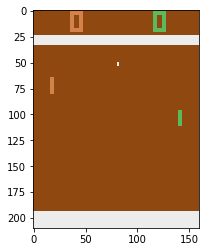

In [7]:
new_observation, reward, done, info = env.step(2)
plt.imshow(observation)

In [9]:
def preprocess_frames(new_frame,last_frame):
    # inputs are 2 numpy 2d arrays
    n_frame = new_frame.astype(np.int32)
    n_frame[(n_frame==144)|(n_frame==109)]=0 # remove backgound colors
    l_frame = last_frame.astype(np.int32)
    l_frame[(l_frame==144)|(l_frame==109)]=0 # remove backgound colors
    diff = n_frame - l_frame
    # crop top and bot 
    diff = diff[35:195]
    # down sample 
    diff=diff[::2,::2]
    # convert to grayscale
    diff = diff[:,:,0] * 299. / 1000 + diff[:,:,1] * 587. / 1000 + diff[:,:,2] * 114. / 1000
    # rescale numbers between 0 and 1
    max_val =diff.max() if diff.max()> abs(diff.min()) else abs(diff.min())
    if max_val != 0:
        diff=diff/max_val
    return diff

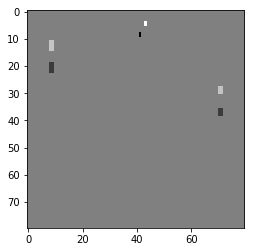

In [10]:
plt.imshow(preprocess_frames(new_observation,observation),plt.cm.gray)

note that we cropped bottom and top of game screen because it did not provide information.
also we remove the backgounds and the pixel values are rescaled between -1 and +1

In [11]:
preprocess_frames(new_observation,observation)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [12]:
preprocess_frames(new_observation,observation).shape

(80, 80)

so our actual **state is a 80*80 image** derived by subtracting two consecutive frames, where as a result most values are 0 but where paddles or ball have moved, it has non-zero values 

next we define a policy which sees the state and chooses an action in keras.

we define our solution approach and network model so that network outputs the probablity of choosing action of moving up. 

# 3. Modeling the Network

In [13]:
# simple 2 layer model 
# with 200 hidden units in first layer
# and 1 sigmoid output
inputs = keras.layers.Input(shape=(80,80))
flattened_layer      = keras.layers.Flatten()(inputs)
full_connect_1       = keras.layers.Dense(units=200,activation='relu',use_bias=False,)(flattened_layer)
full_connect_1       = keras.layers.Dense(units=200,activation='relu',use_bias=False,)(full_connect_1)
full_connect_1       = keras.layers.Dense(units=200,activation='relu',use_bias=False,)(full_connect_1)
sigmoid_output       = keras.layers.Dense(1,activation='sigmoid',use_bias=False)(full_connect_1)
policy_network_model = keras.models.Model(inputs=inputs,outputs=sigmoid_output)
policy_network_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 80, 80)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               1280000   
_________________________________________________________________
dense_2 (Dense)              (None, 200)               40000     
_________________________________________________________________
dense_3 (Dense)              (None, 200)               40000     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 200       
Total params: 1,360,200
Trainable params: 1,360,200
Non-trainable params: 0
_________________________________________________________________


the above model has **about 1.28 million parameters **

you can create any model as you like. based on architecture and complexity of your model, it may train slow or fast, or even not train at all(too hard to train).

here is another model:

In [14]:
# another model
# with convolutional layers 
# it has about 31000 parameters

# inputs = keras.layers.Input(shape=(80,80))
# channeled_input = keras.layers.Reshape((80,80,1))(inputs) # Conv2D requries (batch, height, width, channels)  so we need to create a dummy channel 
# conv_1 = keras.layers.Conv2D(filters=10,kernel_size=20,padding='valid',activation='relu',strides=(4,4),use_bias=False)(channeled_input)
# conv_2 = keras.layers.Conv2D(filters=20,kernel_size=10,padding='valid',activation='relu',strides=(2,2),use_bias=False)(conv_1)
# conv_3 = keras.layers.Conv2D(filters=40,kernel_size=3,padding='valid',activation='relu',use_bias=False)(conv_2)
# flattened_layer = keras.layers.Flatten()(conv_3)
# sigmoid_output = keras.layers.Dense(1,activation='sigmoid',use_bias=False)(flattened_layer)
# policy_network_model = keras.models.Model(inputs=inputs,outputs=sigmoid_output)
# policy_network_model.summary()

so we define a network with an architecture that inputs a 80*80 image and outputs the probability of going up.

in the learning phase the policy can output the probability of going up and we sample from that probability.
in the playing phase we may opt to pick the most probable action. or just sample like the training phase

# 4. Defining loss 

if we write the REINFORCE aglorithm this way:

$\theta = \theta-\alpha G\nabla_{\theta}(-log(\pi))$ 

and see it as a gradient descent, then the loss = $G\nabla_{\theta}(-log(\pi))$

G is the reward from the state we are updating, $\pi$ is the probablity of taking the action that we took when playing. for example when playing the game, probabilty of taking action up was 0.8 according to policy output. but we took down action(because we sample action from probabilty,this is possible) then the loss is G*-log(0.2)

In [15]:
episode_reward = keras.layers.Input(shape=(1,),name='episode_reward')

In [16]:
def m_loss(episode_reward):
    def loss(y_true,y_pred):
        # feed in y_true as actual action taken 
        # if actual action was up, we feed 1 as y_true and otherwise 0
        # y_pred is the network output(probablity of taking up action)
        # note that we dont feed y_pred to network. keras computes it
        
        # first we clip y_pred between some values because log(0) and log(1) are undefined
        tmp_pred = keras.layers.Lambda(lambda x: keras.backend.clip(x,0.05,0.95))(y_pred)
        # we calculate log of probablity. y_pred is the probablity of taking up action
        # note that y_true is 1 when we actually chose up, and 0 when we chose down
        # this is probably similar to cross enthropy formula in keras, but here we write it manually to multiply it by the reward value
        tmp_loss = keras.layers.Lambda(lambda x:-y_true*keras.backend.log(x)-(1-y_true)*(keras.backend.log(1-x)))(tmp_pred)
        # multiply log of policy by reward
        policy_loss=keras.layers.Multiply()([tmp_loss,episode_reward])
        return policy_loss
    return loss

keras loss function has format of `def loss(y_true,y_pred):...`. since we needed to include reward in loss, i created m_loss function above as a tool to input episode_reward as input.

next we create the optimizer and network for training, and:

In [17]:
episode_reward = keras.layers.Input(shape=(1,),name='episode_reward')
policy_network_train = keras.models.Model(inputs=[inputs,episode_reward],outputs=sigmoid_output)

my_optimizer = keras.optimizers.RMSprop(lr=0.0001)
policy_network_train.compile(optimizer=my_optimizer,loss=m_loss(episode_reward),)

**pay attention** to the inputs of policy_network_train defined above. we input both rewards and the inputs(processed 80*80 image).
the output of the network is the same.

since both `policy_network_train` and  `policy_network_model`(defined previous section) use same layers (from inputs to outputs), **they share their weights and parameters**. 
so we just train using `policy_network_train` and then use `policy_network_model` when playing and simlating.

# 5. Reward Engineering and why it is important

let's play with the defined policy and see what is the reward.
we define a function that takes a policy, and plays according to the policy and keeps the rewards.

In [18]:
def generate_episode(policy_network):
    states_list = [] # shape = (x,80,80)
    up_or_down_action_list=[] # 1 if we chose up. 0 if down
    rewards_list=[]
    network_output_list=[]
    env=gym.make("Pong-v0")
    observation = env.reset()
    new_observation = observation
    done = False
    policy_output_list = []
    
    while done == False:
    
        processed_network_input = preprocess_frames(new_frame=new_observation,last_frame=observation)
        states_list.append(processed_network_input)
        reshaped_input = np.expand_dims(processed_network_input,axis=0) # x shape is (80,80) so we need similar reshape(x,(1,80,80))

        up_probability = policy_network.predict(reshaped_input,batch_size=1)[0][0]
        network_output_list.append(up_probability)
        policy_output_list.append(up_probability)
        actual_action = np.random.choice(a=[2,3],size=1,p=[up_probability,1-up_probability]) # 2 is up. 3 is down 
        if actual_action==2:
            up_or_down_action_list.append(1)
        else:
            up_or_down_action_list.append(0)
        
        observation= new_observation
        new_observation, reward, done, info = env.step(actual_action)
        
        rewards_list.append(reward)
        
        if done:
            break
            
    env.close()
    return states_list,up_or_down_action_list,rewards_list,network_output_list

the function is plain and simple, nothing to discuss about it.
so lets play 1 game and see what happens

In [19]:
states_list,up_or_down_action_list,rewards_list,network_output_list = generate_episode(policy_network_model)

In [20]:
print("length of states= "+str(len(states_list)))# this is the number of frames
print("shape of each state="+str(states_list[0].shape))
print("length of rewards= "+str(len(rewards_list)))

length of states= 1104
shape of each state=(80, 80)
length of rewards= 1104


In [21]:
# lets see sample of policy output
print(network_output_list[30:50]) 

[0.51381034, 0.51282734, 0.5185672, 0.5193057, 0.5092307, 0.5036422, 0.51564366, 0.50814664, 0.513842, 0.5023627, 0.5134414, 0.5102778, 0.52033657, 0.50904065, 0.5105204, 0.51147634, 0.5078517, 0.5163732, 0.51223326, 0.506339]


since the network is not trained, its output is about 50% all time. meaning . that it does not know which action is better now and outputs a probablity of about 0.5 for all states

In [22]:
#lets see a sample what we actually did: 1 means we went up, 0 means down
up_or_down_action_list[30:50]

[1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1]

In [23]:
# lets see sample of rewards
print(rewards_list[50:100]) 

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


So the rewards are mostly zero and sometimes we may see 1 or -1 in list. this is because environment just gives us reward when ball passes through us or through opponent. 

when ball passes our paddle, we lose and get -1 reward and when the opponent fails to catch the ball, we win and get +1.

In [24]:
# lets see how many times we won through whole game:
print("count win="+str(len(list(filter(lambda r: r>0,rewards_list)))))
print("count lose="+str(len(list(filter(lambda r: r<0,rewards_list)))))
print("count zero rewards="+str(len(list(filter(lambda r: r==0,rewards_list)))))

count win=0
count lose=21
count zero rewards=1083


so we got a lot of zeros. some loses. and maybe some wins if we are lucky and our dumb network did some lucky actions in some situation. lets plot the reward

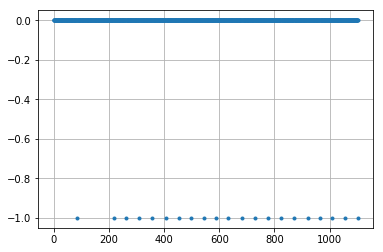

In [25]:
plt.plot(rewards_list,'.')
ax=plt.gca()
ax.grid(True)

### *if we train our network with this reward, it learns nothing*
because the reward is most of the time zero. in this case the agent does not get feedback what is good or bad. most gradients become zero because we multiply by reward in the mentioned algo.

it looks like the environment just rewards us when the ball passes through our paddel(we score -1) or our opponent's paddle(we score +1).

now think about it:

our paddle moves up and down, hits the ball and the ball travels to the left side of the screen. the opponent fails to catch it and we win and get a score of 1. 

in this scenario, which actions were actually good? 

* the action we took when we hit the ball? 
* the action we took when we get score of 1?

of course the first option is correct. 
the second option is wrong, because when the ball is reaching the opponent, our action does not matter. only the action that we took to hit the ball were important to winning. and everything after hitting the ball was irrelevant to our win. 

(a rather similar argument can be discussed about losing, the actions near when we got score of -1 is more important than actions taken many steps earlier)

**so here is the trick.**

we set the reward of actions taken before each reward, similar to the reward obtained.

for example if we got reward +1 at time 200, we say that reward of time 199 is +0.99, reward of time 198 is +0.98 and so on. 

with this reward definition, we have the rewards for actions that actually resulted in a +1 or -1. and we assume the more recent the action to the reward gained, the more important it is.

we define a function below, that does this for us. 

note that this may not be applicable in other environments, but serves our purposes for this project

In [26]:
def process_rewards(r_list):
    reward_decay=0.99
    tmp_r=0
    rew=np.zeros_like(r_list,dtype=np.float32)
    for i in range(len(r_list)-1,-1,-1):
        if r_list[i]==0:
            tmp_r=tmp_r*reward_decay
            rew[i]=tmp_r
        else: 
            tmp_r = r_list[i]
            rew[i]=tmp_r
    return rew

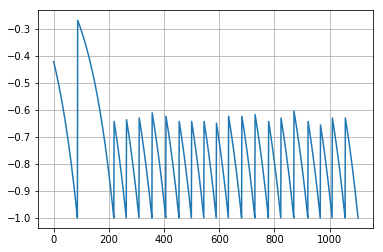

In [27]:
# lets see what this gives us:
plt.plot(process_rewards(rewards_list),'-')
ax=plt.gca()
ax.grid(True)

you can see that in the above chart we got better distribution for rewards. reward is -1 where it was -1 and now steps before it has some value near -1 (for example -0.9) and similar process happens for positive rewards. 

further more we refine the function to subtract rewards by mean and divide by std, and then discuss the results.

In [28]:
def process_rewards(r_list):
    reward_decay=0.99
    tmp_r=0
    rew=np.zeros_like(r_list,dtype=np.float32)
    for i in range(len(r_list)-1,-1,-1):
        if r_list[i]==0:
            tmp_r=tmp_r*reward_decay
            rew[i]=tmp_r
        else: 
            tmp_r = r_list[i]
            rew[i]=tmp_r
    rew -= np.mean(rew) # subtract by average
    rew /= np.std(rew) # divide by std
    return rew

note that we normalized the rewards, subtracting by mean and dividing by std. this may not be perfect but works for this project.(more discussion after the plot)

lets see our reformatted rewards: 

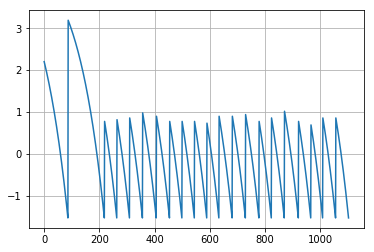

In [29]:
plt.plot(process_rewards(rewards_list),'-',)
ax=plt.gca()
ax.grid(True)

so now we have non zero rewards most of the time. 

in points we got -1 reward, the new score is aout -1.5 as seen above and steps before it also have negative rewards. the negativity of the reward goes down as we go to the left from each -1.5 score. 

### some discussion about positive rewards in early steps of losing episodes:
also you can see that we got some positive scores in our new chart. this is because we subtracted by mean.
think about what it can result?

the positive reward happens in the long sequences of playing. these are situations where we catched the ball and didnt get a -1 immediately, but we lost later because we failed to catch the ball when it came toward us.

setting a negative score is logical because we ended up getting a -1. setting a positive score could be justified by that we approve actions where we catched the ball and did not get -1 reward immediately (maybe we didnt win either)

the above scoring method could prove a bit problematic when we are winning. it may discourage actions in early steps of a sequence which ends in winning. but we dont further consider discuss it here. 

so now that we have defined our rewards, we can go to next step and start training the network. 

# 6. Example of simluation and training

In [30]:
# first generate an episode:
states_list,up_or_down_action_list,rewards_list,network_output_list = generate_episode(policy_network_model)

In [31]:
print("length of states= "+str(len(states_list)))# this is the number of frames
print("shape of each state="+str(states_list[0].shape))
print("length of rewards= "+str(len(rewards_list)))

length of states= 1357
shape of each state=(80, 80)
length of rewards= 1357


In [32]:
#preprocess inputs for training: 
    
x=np.array(states_list)

episode_reward=np.expand_dims(process_rewards(rewards_list),1)

y_tmp = np.array(up_or_down_action_list) # 1 if we chose up, 0 if down
y_true = np.expand_dims(y_tmp,1) # modify shape. this is neccassary for keras


print("episode_reward.shape =",episode_reward.shape)
print("x.shape =",x.shape)
print("y_true.shape =",y_true.shape)

episode_reward.shape = (1357, 1)
x.shape = (1357, 80, 80)
y_true.shape = (1357, 1)


In [33]:
# fit the model with inputs and outputs.
policy_network_train.fit(x=[x,episode_reward],y=y_true)

Epoch 1/1
1357/1357 [==============================] - 1s 632us/step - loss: 7.7225e-04


# 7. Training the network

for the actual training, we generate some episode, then train on the batch. 
we can also log the rewards to keep records

In [34]:
# we define a helper function to create a batch of simulations
# and after the batch simulations, preprocess data and fit the network
def generate_episode_batches_and_train_network(n_batches=10):
    env = gym.make('Pong-v0')
    batch_state_list=[]
    batch_up_or_down_action_list=[]
    batch_rewards_list=[]
    batch_network_output_list=[]
    for i in range(n_batches):
        states_list,up_or_down_action_list,rewards_list,network_output_list = generate_episode(policy_network_model)   
        batch_state_list.extend(states_list[15:])
        batch_network_output_list.extend(network_output_list[15:])
        batch_up_or_down_action_list.extend(up_or_down_action_list[15:])
        batch_rewards_list.extend(rewards_list[15:])
    
    episode_reward=np.expand_dims(process_rewards(batch_rewards_list),1)
    x=np.array(batch_state_list)
    y_tmp = np.array(batch_up_or_down_action_list)
    y_true = np.expand_dims(y_tmp,1)
    policy_network_train.fit(x=[x,episode_reward],y=y_true)

    return batch_state_list,batch_up_or_down_action_list,batch_rewards_list,batch_network_output_list

we write a script to save the model in a file and log rewards from time to time.

In [ ]:
train_n_times = 21 # for actual training, about 5000 may be a good start. 
for i in range(train_n_times):
    states_list,up_or_down_action_list,rewards_list,network_output_list=generate_episode_batches_and_train_network(10)
    if i%10==0:
        print("i="+str(i))
        rr=np.array(rewards_list)
        # i keep how many times we won in batch. you can use log more details more frequently
        print('count win='+str(len(rr[rr>0]))) 
        policy_network_model.save("policy_network_model_simple.h5")
        policy_network_model.save("policy_network_model_simple"+str(i)+".h5")
        with open('rews_model_simple.txt','a') as f_rew:
            f_rew.write("i="+str(i)+'       reward= '+str(len(rr[rr > 0])))
            f_rew.write("\n")

i let it train for some batches here for presentation purposes. **in actual training we should let it run for much more episodes**.(about 1000 to 100000)

the model we defined earlier had 1.28 million params. so the process of simulation and training is kind of slow. u can try and simplify the model or maybe use convolutional models.

# 8. Playing the Trained Network

In [ ]:
import time
def play_and_show_episode(policy_network):
    env = gym.make('Pong-v0')
    done=False
    observation = env.reset()
    new_observation = observation
    while done==False:
        time.sleep(1/80)
        
        processed_network_input = preprocess_frames(new_frame=new_observation,last_frame=observation)
        reshaped_input = np.expand_dims(processed_network_input,axis=0) # x shape is (80,80) so we need similar reshape(x,(1,80,80))

        up_probability = policy_network.predict(reshaped_input,batch_size=1)[0][0]
        actual_action = np.random.choice(a=[2,3],size=1,p=[up_probability,1-up_probability])
        
        env.render()
        
        observation= new_observation
        new_observation, reward, done, info = env.step(actual_action)
        if reward!=0:
            print(reward)
        if done:
            break
        
    env.close()

In [ ]:
play_and_show_episode(policy_network_model)

if you have trained the network for some amount of time, you can see that the agent has learned some tricks to defend and even win.

note that the default model with 1.2 million params we defined earlier may take a huge amount of training to learn to win sometimes.

# 9. Loading model from file

you can load model from file and play the game or even continue training it. 

here i load one of my trained files. it is the same model with 1.28 million paramteres, trained for 1550 on batches of 10 simulations, which means 15500 games in total. it is still not intelligent, but not dumb either.

In [10]:
policy_network_model=keras.models.load_model("trained_simple_model_3300.h5")
policy_network_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 80, 80)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               1280000   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 200       
Total params: 1,280,200
Trainable params: 1,280,200
Non-trainable params: 0
_________________________________________________________________


/Users/soroush/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


since keras does not save the custom loss in the file we should redefine loss function and training model.

note that this is not needed if you dont want to continue the training of the saved model.

In [38]:
episode_reward = keras.layers.Input(shape=(1,),name='episode_reward')

def m_loss(episode_reward):
    def loss(y_true,y_pred):
        # feed in y_true as actual action taken
        # loss = reward*(-actual*np.log(y_pred)-(1-actual)*np.log(1-y_pred)))
        
        tmp_pred = keras.layers.Lambda(lambda x: keras.backend.clip(x,0.05,0.95))(y_pred) # we could also do gradient clipping
        tmp_loss = keras.layers.Lambda(lambda x:-y_true*keras.backend.log(x)-(1-y_true)*(keras.backend.log(1-x)))(tmp_pred)
        # put reward in effect
        policy_loss=keras.layers.Multiply()([tmp_loss,episode_reward])
        
        return policy_loss
    return loss

policy_network_train = keras.models.Model(inputs=[policy_network_model.input,episode_reward],outputs=policy_network_model.output)
my_optimizer = keras.optimizers.RMSprop(lr=0.0001)
policy_network_train.compile(optimizer=my_optimizer,loss=m_loss(episode_reward),)

In [67]:
play_and_show_episode(policy_network_model)

1.0
1.0
1.0
-1.0
1.0
-1.0
1.0
1.0
1.0
-1.0
1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
1.0
1.0
1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0


# 10. Using Convolutional Model

In [40]:
policy_network_model=keras.models.load_model("trained_conv_model.h5")
policy_network_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 80, 80)            0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 80, 80, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 10)        4000      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 20)          20000     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 2, 2, 40)          7200      
_________________________________________________________________
flatten_1 (Flatten)          (None, 160)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 160       
Total para

/Users/soroush/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [68]:
play_and_show_episode(policy_network_model)

-1.0
-1.0
1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0


In [41]:
%%HTML
<video width="320" height="420" controls>
  <source src="trained_convolutional_network.mp4" type="video/mp4">
</video>

# 11. Ideas & Thoughts


as you can see, both simple and convolutional models have learned to play and score some points.

our simple network takes more time for each simulation and training. the convolutional model takes less amount of time both for simulation and playing. probably because it has less parameters.

I played around a bit with convolutional models. the problem with them was that they get stuck in the bottom or top of the game, and it is hard for them to learn to get out of that situation. 

I didn't want to make perfect agents, but if you want, you can try and train the networks a lot more so they can play better.

I had access to high performance computing system of my university which has about 30 cores of cpu. The training on my own pc was much faster because of the clock of cpu (the cluster just has many weak cpus), but used the university cluster since it could train day and night. It took the simple network took about 3 days to run 1550 batches of 10 game simulations on the cluster.

Here are some ideas to improve the training and agents:

* **generate simulations of batches in parallel**. I tried using multithreading to generate and play batches of games at the same time to increase the speed of data generation. the problem was that the backend library for the game had issues creating environments in multiple threads. maybe you can overcome this by implementing a multiprocess method. 

* The convolutional models I used were very fast at generating actions and also training. Their problem was that after some training, they learned some tricks fast but took a lot of time for them to learn something new. The agent just stuck in the up or bottom of game screen and didnt try new things to score and learn. I think **using an epsilon-greedy policy** can improve the exploration of the networks.which means that each action has a minimum probablity of being chosen(for example 20%). Another idea could be **using off-policy method** which means another more explorative policy(for example a policy that just takes random actions) plays the game, and our target policy learns from the experience generated by the explorative policy.

* giving a reward to the agent for catching the ball could be good for not losing(for example a +0.5 reward). now we are just giving positive reward to agent for scoring. if it catched the ball and then got a -1 reward, it thinks it was probably bad that it catched the ball.  

* tuning the optimizer parameters may be helpful. I just modified learning rate a bit. 

**some thoughts about the agents' mind:**

We are far from general intelligence. The agent has no sense if there is a ball which moves around and hits and ricochets from walls and paddles. It has no notion of physics of the game. All it sees is that some neurons of the input fires and it take some actions. unlike a human, if he sees the ball moving in a new position and direction that it had not seen before, it cannot generalize from his past experience. It has no notion of the ball, environment, itself, reward and punishment and... the agent is just a regression model.this article might be interesting: https://medium.com/syncedreview/interview-with-dr-richard-sutton-we-might-have-strong-ai-algorithms-by-2030-a1052332d878

# 12. References and Suggested readings

great blog post by Andrej Karpathy: http://karpathy.github.io/2016/05/31/rl/
this project is actually re implementing the above blog post with some explanations on the coding and implementation. 

Richard Sutton has a great book: Reinforcement Learning: An Introduction. 
The book is kind of a bible for reinforcement learning. At the time of writing this, the draft of second version is available online. http://incompleteideas.net/book/the-book-2nd.html